# Introduction, Motivation and/or Problem Statement

The ability of an AI to play video games comparably to a human, has been a great interest in the AI community. AI has managed to succeed in a wide variety of games, but in a lot of cases the AI is directly fed in the data rather than obtaining it through what's shown on the screen. As such, these AI models do not accurately reflect a human player, since they have access to exact data values and information which a human player would be unable to infer from looking at the screen. However, the paper Playing Atari with Deep Reinforcement Learning (https://arxiv.org/pdf/1312.5602.pdf), showed that the game Atari Breakout was playable by a deep learning model which inferred all the information needed directly from the screen through the use of a CNN. This type of model is a better representation of an AI playing a game in the same way a human player would.

The game Flappy Bird has been a popular choice for the testing of new deep learning models which are designed for games. These models fall under the area of reinforcement learning. When training reinforcement learning models in game-playing capabilities, a common trend is to utilise genetic models such as the NEAT algorithm, Experience replay models like Deep Q-Learning or model-free methods such as Q-Learning. Many of these methods require a direct tap into the variables of the game and as a result, rely on self-implementations that don’t directly reflect the true state of the game. Furthermore, a model knowing the exact values of variables isn’t reflective of a human player playing the game.  

As a result, the aim of this project is to implement a model that utilises CNN classification techniques alongside the game ‘Flappy Bird’ to identify game objects, and provide data to another reinforcement learning algorithm. This should allow the model to be used on any implementation of ‘Flappy Bird’, regardless of game screen size or implementation specific variables, giving the implementation an edge over other models in applicability. Also, a CNN gathering information from the pixels is better representative of a human player, who acts solely based on what’s shown on the screen. From prior research, it has been hypothesised that the Deep Q-Learning model, with its capability to generalise actions over large datasets will be the most suitable approach to combine with this CNN model.

# Data Sources or RL Task

The task is to teach a model to play the game of flappy bird perfectly. The flappy bird game involves a bird which is usually controlled by a human player. The bird has 1 action which it can take, *flap*, which causes the bird to increase its height and stop it from falling temporarily. There are also a sequence of vertical pipe pairs which are seperated by a gap and the player receives a score point if the bird can fly through the gap without hitting the pipes. If the bird flies into one of the pipes or hits the ground, the player loses. The goal of the game is to fly as long as possible through the pipe gaps and get the highest score without colliding with the pipes or ground. This is summarised in the images below.

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExdXVqamh0b3hmOWJtajZuYzNlNmhlNHl5dTdyYmo1NzBmcDZ6dzVtayZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/MjMnKwWB6GNh09y6ya/giphy.gif" width="200" height="400" />

<em>Shows a bird training and losing after flying too high or hitting a pipe.</em>

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExbWdyanVscWtwbzU3YzJnbzNpZGFjNmx1dTE2bDlvdnFhazhlbDdodSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/lBaThIMmug2o06ZPEZ/giphy.gif" width="400" height="400" />

<em>Shows a trained bird that can successfully fly through the pipes.</em>

Most deep learning model attempts at Flappy Bird rely on the input data being directly provided to the model. However, there has been attempts at using a CNN to infer the data from the screen. Github user yenchenlin (https://github.com/yenchenlin/DeepLearningFlappyBird), built a working implementation of a CNN + QLearning model which is able to play the game. However, it should be noted that in his implementation, the game is quite forgiving. This implementation has lower pipe velocity and slower bird movement, allowing for the model to make a mistake without dying. This however isn't an accurate representation of the Flappy Bird game, which was originally quite fast paced. So, in order to preserve accuracy, we decided to make the game as difficult as the original game, keeping a high pipe velocity and quick bird movements. As a result, if the model makes a single mistake it will always lose.

The game can be played by running the next 5 cells if the image assets are given.

In [ ]:
class Bird:
    def __init__(self):
        self.vel = 0
        self.x = BIRD_SIZE
        self.y = SCREEN_HEIGHT // 2 - 25
        self.tick_count = 0

    def move_bird(self):
        self.vel += GRAVITY
        self.y += self.vel

    def flap(self):
        self.vel = -10.5

In [ ]:
import pygame
import random
import pickle
import os
import torch

SCREEN_WIDTH = 550
SCREEN_HEIGHT = 850
BIRD_SIZE = 50
PIPE_WIDTH = 75
GAP_SIZE = 200
PIPE_HEIGHT = PIPE_WIDTH * 854 / 52
VISUALISE = True
MAX_FRAME_RATE = 60
FITNESS_THRESHOLD = 100
GRAVITY = 0.6


screenshots = torch.empty(0,3,600,800)
frames = []
output = []
outputs = torch.empty(0,3)
moved = False

class Game:
    def __init__(self, screen):
        self.screen = screen
        self.clock = pygame.time.Clock()
        self.bird = Bird()
        self.pipe_height1 = random.randint(100, 400)
        self.pipe_x1 = SCREEN_WIDTH
        self.pipe_height2 = random.randint(100, 400)
        # manually found starting value for x2 for pipes to be equidistant
        self.pipe_x2 = 1.5 * SCREEN_WIDTH + 40
        self.score = 0

    def move_pipes(self):
        self.pipe_x1 -= 5
        self.pipe_x2 -= 5
        if self.pipe_x1 < -PIPE_WIDTH:
            self.pipe_x1 = SCREEN_WIDTH
            self.pipe_height1 = random.randint(100, SCREEN_HEIGHT - GAP_SIZE)
            self.score += 1
            return True
        elif self.pipe_x2 < -PIPE_WIDTH:
            self.pipe_x2 = SCREEN_WIDTH
            self.pipe_height2 = random.randint(100, SCREEN_HEIGHT - GAP_SIZE)
            self.score += 1
            return True
        return False


    def check_collisions(self, bird):
        collision_occurred = False
        if bird.y > SCREEN_HEIGHT or bird.y < -BIRD_SIZE:
            collision_occurred = True
        if bird.x + BIRD_SIZE > self.pipe_x1 and bird.x < self.pipe_x1 + PIPE_WIDTH:
            if bird.y < self.pipe_height1 or bird.y + BIRD_SIZE > self.pipe_height1 + GAP_SIZE:
                collision_occurred = True
        elif bird.x + BIRD_SIZE > self.pipe_x2 and bird.x < self.pipe_x2 + PIPE_WIDTH:
            if bird.y < self.pipe_height2 or bird.y + BIRD_SIZE > self.pipe_height2 + GAP_SIZE:
                collision_occurred = True
        return collision_occurred

    def process_game_events(self):
        global moved
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return True
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP:
                    self.bird.flap()
                    moved = True
        return False

    def draw_game(self, birds):
        global SCREEN
        pipe_img = pygame.transform.scale(pygame.image.load(os.path.join("NEATandDeepQ","imgs","pipe.png")).convert_alpha(), (PIPE_WIDTH, PIPE_HEIGHT))
        bg_img = pygame.transform.scale(pygame.image.load(os.path.join("NEATandDeepQ","imgs","bg.png")).convert_alpha(), (600, 900))
        bird_img = pygame.transform.scale(pygame.image.load(os.path.join("NEATandDeepQ","imgs","bird.png")).convert_alpha(), (BIRD_SIZE, BIRD_SIZE))
        base_img = pygame.transform.scale2x(pygame.image.load(os.path.join("NEATandDeepQ","imgs","floor.png")).convert_alpha())
        self.screen.blit(bg_img, (0,0))
        for bird in birds:
            #pygame.draw.rect(self.screen, (255, 255, 255,10), (bird.x, bird.y, BIRD_SIZE, BIRD_SIZE))
            self.screen.blit(bird_img, (bird.x,bird.y))
        #pygame.draw.rect(self.screen, (255, 255, 255), (self.pipe_x1, 0, PIPE_WIDTH, self.pipe_height1))
        #pygame.draw.rect(self.screen, (255, 255, 255), (self.pipe_x1, self.pipe_height1 + GAP_SIZE, PIPE_WIDTH, SCREEN_HEIGHT - self.pipe_height1 - GAP_SIZE))
        self.screen.blit(pipe_img, (self.pipe_x1, self.pipe_height1 + GAP_SIZE))
        self.screen.blit(pygame.transform.flip(pipe_img, False, True), (self.pipe_x1, self.pipe_height1 - PIPE_HEIGHT))

        #pygame.draw.rect(self.screen, (255, 255, 255), (self.pipe_x2, 0, PIPE_WIDTH, self.pipe_height2))
        #pygame.draw.rect(self.screen, (255, 255, 255), (self.pipe_x2, self.pipe_height2 + GAP_SIZE, PIPE_WIDTH, SCREEN_HEIGHT - self.pipe_height2 - GAP_SIZE))
        self.screen.blit(pipe_img, (self.pipe_x2, self.pipe_height2 + GAP_SIZE))
        self.screen.blit(pygame.transform.flip(pipe_img, False, True), (self.pipe_x2, self.pipe_height2 - PIPE_HEIGHT))

        pygame.display.update()

    def run(self):
        # initial screen
        if VISUALISE:
            self.draw_game([self.bird])
        intial_running = True
        while intial_running:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    exit(0)
                if event.type == pygame.KEYDOWN:
                    intial_running = False
        # Game loop
        while True:
            # if quit signal returned, end game
            if self.process_game_events(): break
            # move game entities
            self.bird.move_bird()
            self.move_pipes()
            # if collision occurred, end game
            if self.check_collisions(self.bird): break
            # Update display
            if VISUALISE: self.draw_game([self.bird])
            pygame.display.update()
            self.clock.tick(MAX_FRAME_RATE)
        print(self.score)

In [ ]:
# play the game
pygame.init()
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
game_instance = Game(screen)
game_instance.run()
pygame.quit()

The RL task is to train the bird to achieve a high score and be able to fly perfectly through the pipes. When training reinforcement learning models in game-playing capabilities, a common trend is to utilise genetic models such as the NEAT algorithm, Experience replay models like Deep Q-Learning or model-free methods such as Q-Learning. Many of these methods require a direct tap into the variables of the game and as a result, rely on self-implementations that dont directly reflect the true state of the game. As a result, the aim of this paper is to implement a model that utilises CNN classification techniques to identify game objects, and provide data to another algorithm for Reinforced Learning. This should allow the model to be used on any implementation of Flappy Bird, regardless of gamescreen size or particular game assets, giving the implementation an edge over other models. From prior research, it has been hypothesised that the Deep Q-Learning model, with its capability to generalise actions over large datasets will be the most suitable approach to combine with this CNN model.

# Exploratory Analysis of Data or RL Tasks

The RL task relies on having input information to base its decision on. In this game, the input data values are:

- The Bird's x coordinate
- The Bird's y coordinate
- The first pipe's x coordinate
- The first pipe's y coordinate
- The second pipe's x coordinate
- The second pipe's y coordinate

The output of a given model will be the decision on whether to flap or not (a boolean value).

The constants for this environment include:
Scaled game
- Screen width: 288
- Screen height: 512
- Vertical gap between pipes: 100
- Pipe velocity: 4

Non-scaled game
- Screen width: 550
- Screen height: 850
- Vertical gap between pipes: 150
- Pipe velocity: 4

Whilst most models for games are fed this data directly in the program, the project will also use a CNN approach which only utilises the screen pixels and no direct data. The CNN model will approximate the input data values from above and feed them into a Deep Q-Learning or Q-Learning model, depending on which performs better. For this type of model, preprocessing is applied on the images of the game. This data is generated by running a model from the Q-Learning method and saving each frame as a tensor as well as the corresponding input data values (defined above). Each frame of the game will have 3 channels corresponding to red, blue, and green. In pygame, each of these values range from 0 to 255 and so to standardise the values, each of the channel values is divided by 255. The training data values are also normalised by dividing by either the screen height or width depending on which data value it is. For example, the bird's y-coordinate is in the range of 0 to SCREEN_HEIGHT and so it is divided by the SCREEN_HEIGHT to give a normalised value between 0 and 1. The code to obtain the input data is shown in the CNN section in methods.

A diagram showing the preprocessing of the image is shown below.

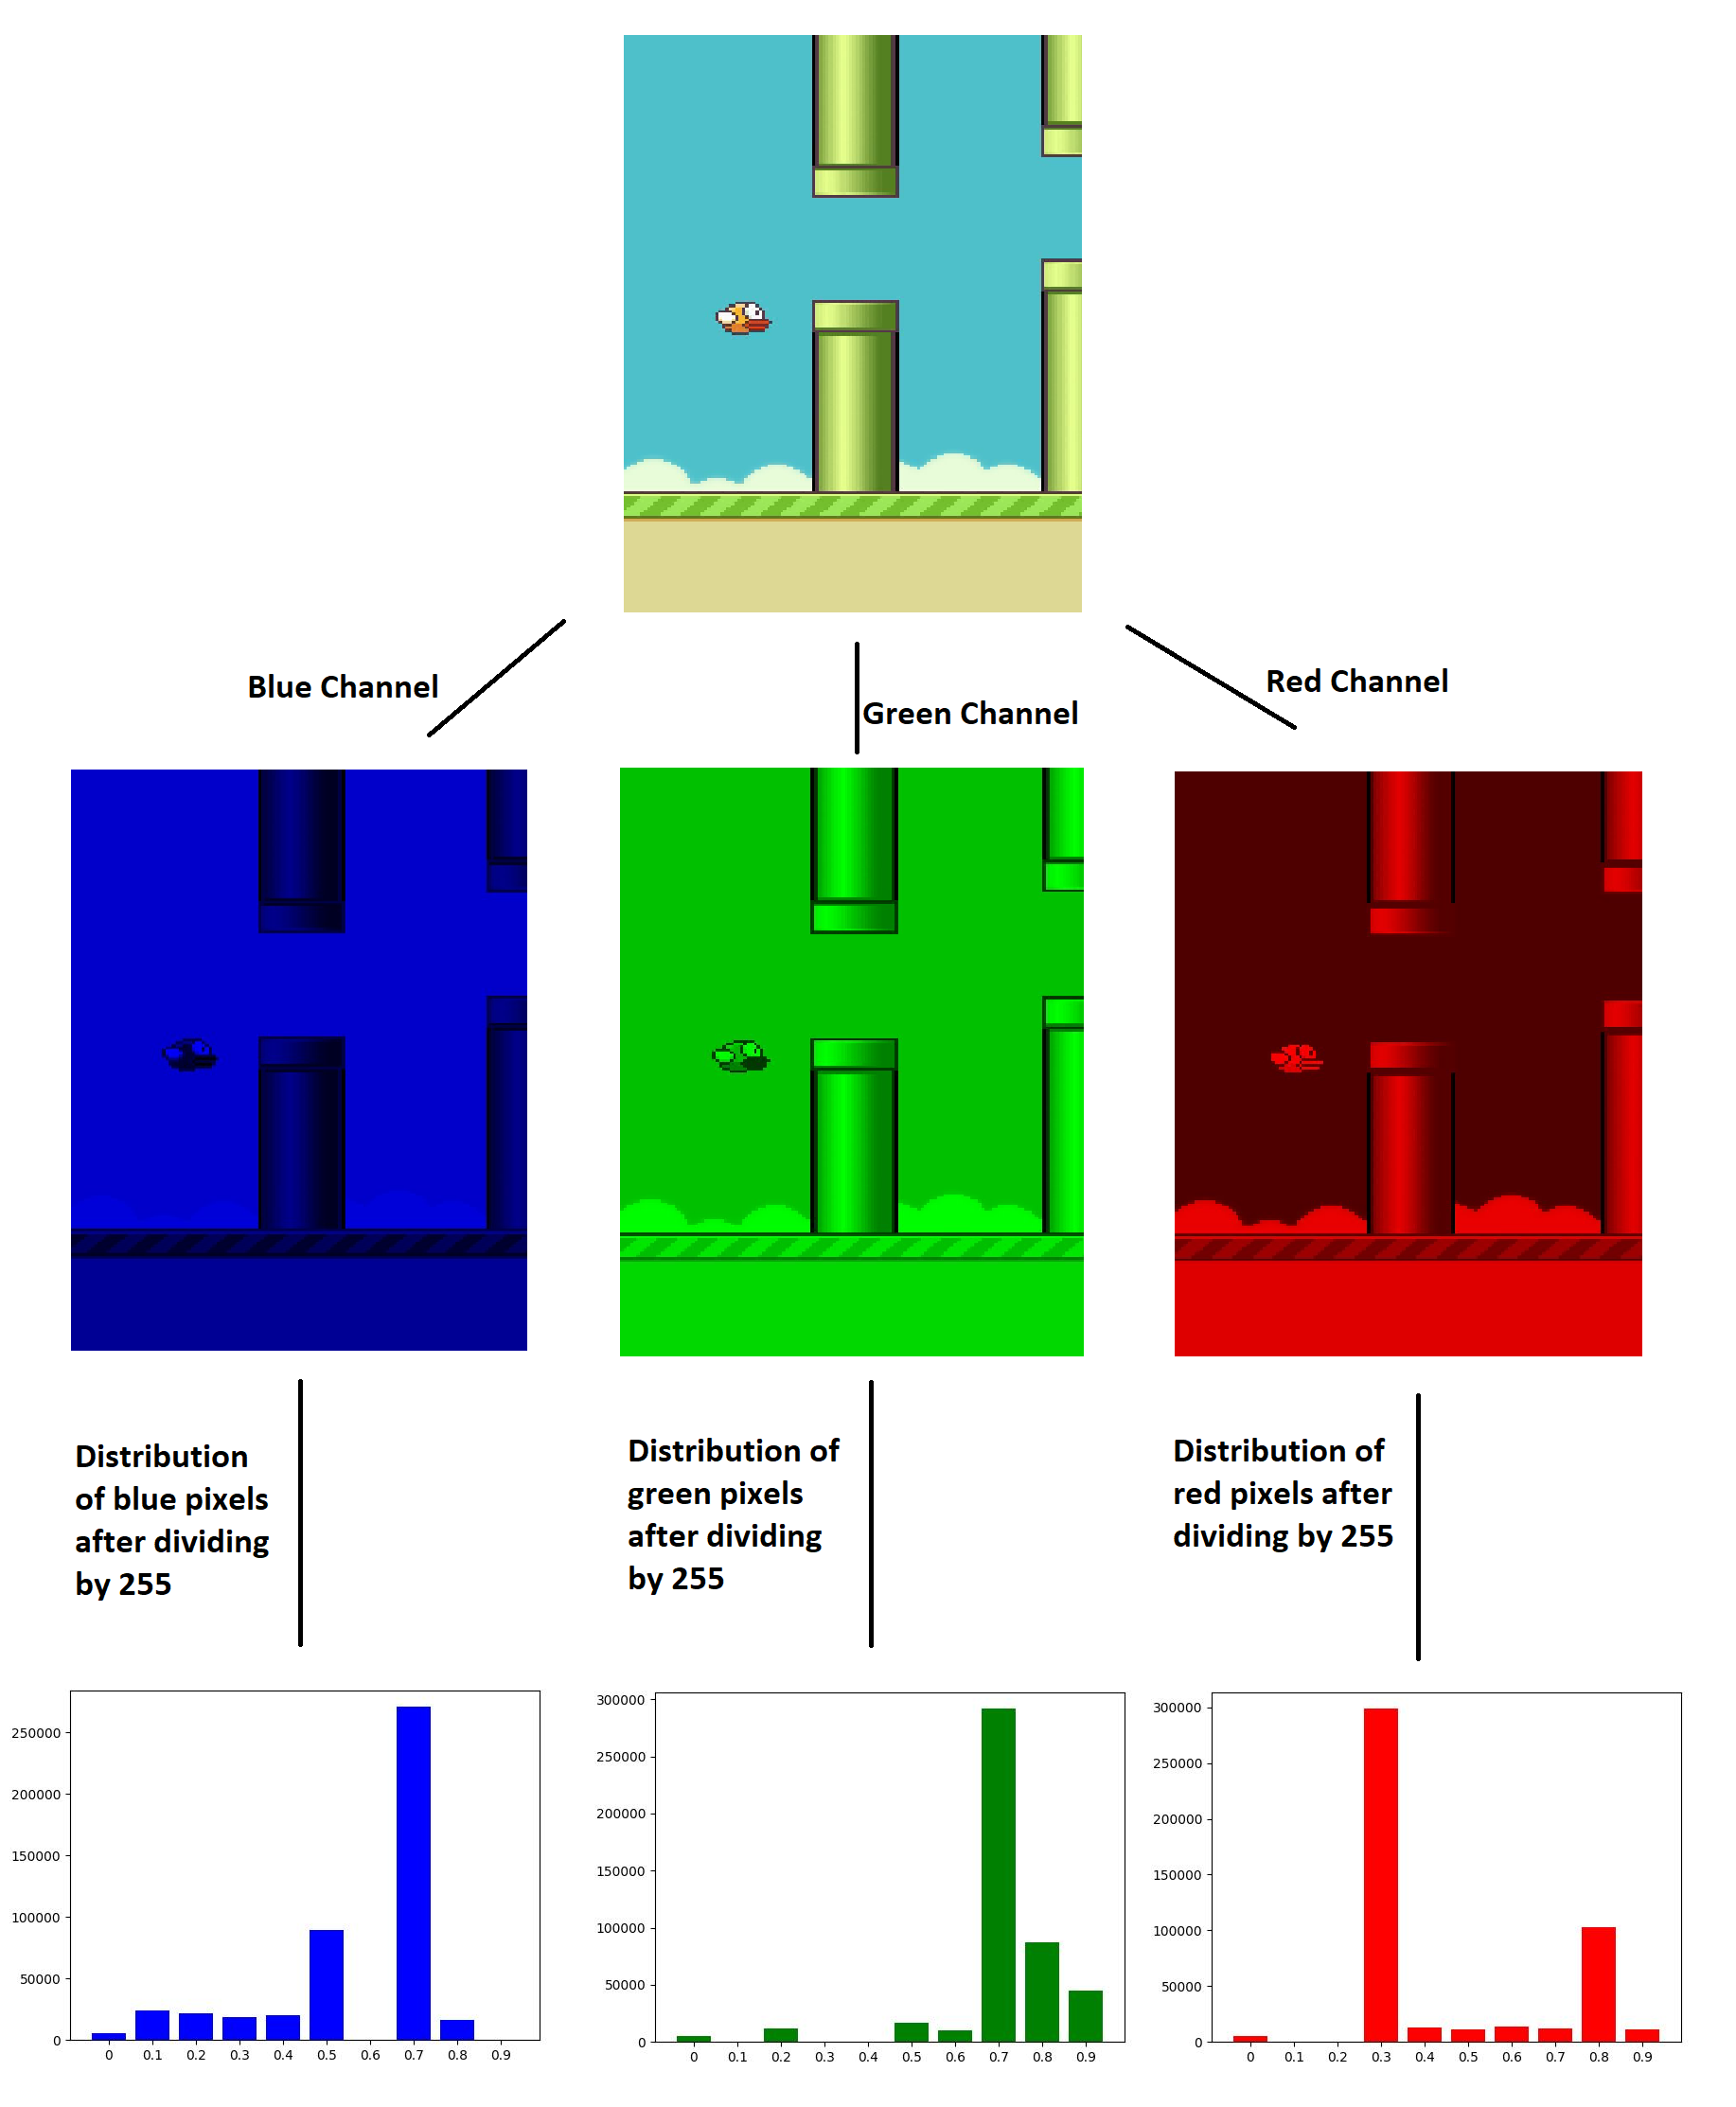

# Models and/or Methods

### Code
This project required a large amount of code, and so for the sake of readability only the most important parts are put in this notebook. We were given permission by Sonit to have the rest of the backend code on gitlab which can be found here https://nw-syd-gitlab.cseunsw.tech/z5363662/perceptron_party_comp9444 



### Q-Learning
The Q-Learning method, was directly based on and inspired by the method found here: https://github.com/anthonyli358/FlapPyBird-Reinforcement-Learning/tree/master

As this course covers Deep-Learning, we thought it was not appropriate, or necessary to re-implement a method that did not use Deep Learning at all. As a result, we used this method, and modified it to work with our testing environment, and used it to give some baseline data and understanding for our Deep Q and NEAT models. These modifications included:
- Allowing for no velocity in the Q-Learning
- Scaling the Gameboard
- Removing unnecessary assets
- Removing functions
- Modifying existing functions to remove non-useful functionality
- Changing config file to easily swap these parameters

These changes made it much easier to replicate our desired testing environment and allowed our model to be fair in comparison to the other methods.

Also the function plot_learning_curve() is used to generate the graphs in our results.

The following is the modified code from `flappy_rl.py`:


In [ ]:
from itertools import cycle
from collections import deque
import copy
import random
import sys
import pygame
from pygame.locals import *
import matplotlib.pyplot as plt
import time
import numpy as np

# Initialize Q-learning agent
from config import config
from q_learning import QLearning

Agent = QLearning(config["train"])

if Agent.train:
    print("Training agent...")
else:
    print("Running agent...")

cumulative_reward = []

# Back to game

FPS = 30
if config["scaled"]:
    SCREENWIDTH = 550
    SCREENHEIGHT = 850
    PIPEGAPSIZE = 150
else:
    SCREENWIDTH = 288
    SCREENHEIGHT = 512
    PIPEGAPSIZE = 100
BASEY = SCREENHEIGHT * 0.79
# image, sound and hitmask  dicts
IMAGES, SOUNDS, HITMASKS = {}, {}, {}
STATE_HISTORY = deque(maxlen=70)  # 70 is distance between pipes
REPLAY_BUFFER = []

# list of all possible players (tuple of 3 positions of flap)
PLAYER = "imgs/bird1.png"

# list of backgrounds
BACKGROUND = "imgs/bg.png"

# list of pipes
PIPE = "imgs/pipe.png"
try:
    xrange
except NameError:
    xrange = range


def main():
    global SCREEN, FPSCLOCK
    pygame.init()
    FPSCLOCK = pygame.time.Clock()
    SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
    pygame.display.set_caption("Flappy Bird")

    while True:
        IMAGES["base"] = pygame.image.load("imgs/base.png").convert_alpha()
        # select random background sprites
        IMAGES["background"] = pygame.image.load(BACKGROUND).convert()

        # select random player sprites

        IMAGES["player"] = pygame.image.load(PLAYER).convert_alpha()

        # select random pipe sprites
        IMAGES["pipe"] = (
            pygame.transform.flip(pygame.image.load(PIPE).convert_alpha(), False, True),
            pygame.image.load(PIPE).convert_alpha(),
        )

        if config["scaled"]:
            for image in ["player", "background", "base"]:
                IMAGES[image] = pygame.transform.scale_by(IMAGES[image], 2)
            IMAGES["pipe"] = (
                pygame.transform.scale_by(IMAGES["pipe"][0], 2),
                pygame.transform.scale_by(IMAGES["pipe"][1], 2),
            )
        # hismask for pipes
        HITMASKS["pipe"] = (
            getHitmask(IMAGES["pipe"][0]),
            getHitmask(IMAGES["pipe"][1]),
        )

        # hitmask for player
        HITMASKS["player"] = getHitmask(IMAGES["player"])

        movementInfo = {
            "playery": int((SCREENHEIGHT - IMAGES["player"].get_height()) / 2),
            "basex": 0,
        }
        crashInfo = mainGame(movementInfo)
        showGameOverScreen(crashInfo)


def mainGame(movementInfo):
    # --- REMOVE ANGULAR MOVEMENT AND SOUNDS ---

    score = loopIter = 0
    playerx, playery = int(SCREENWIDTH * 0.2), movementInfo["playery"]

    basex = movementInfo["basex"]
    baseShift = IMAGES["base"].get_width() - IMAGES["background"].get_width()

    # get 2 new pipes to add to upperPipes lowerPipes list
    newPipe1 = getRandomPipe()
    newPipe2 = getRandomPipe()

    # list of upper pipes
    upperPipes = [
        {"x": SCREENWIDTH + 200, "y": newPipe1[0]["y"]},
        {"x": SCREENWIDTH + 200 + (SCREENWIDTH / 2), "y": newPipe2[0]["y"]},
    ]

    # list of lowerpipe
    lowerPipes = [
        {"x": SCREENWIDTH + 200, "y": newPipe1[1]["y"]},
        {"x": SCREENWIDTH + 200 + (SCREENWIDTH / 2), "y": newPipe2[1]["y"]},
    ]

    pipeVelX = -4

    # player velocity, max velocity, downward accleration, accleration on flap
    playerVelY = -9  # player's velocity along Y, default same as playerFlapped
    playerMaxVelY = 10  # max vel along Y, max descend speed
    playerAccY = 1  # players downward accleration
    playerFlapAcc = -9  # players speed on flapping
    playerFlapped = False  # True when player flaps

    # When starting the game, if we have state history to resume from then use it until it passes that pipe
    # If history is less than 20 frames this isn't enough for the bird to learn from (loop of dying) so clear the queue
    if len(STATE_HISTORY) < 20:
        STATE_HISTORY.clear()
    resume_from_history = (
        len(STATE_HISTORY) > 0 if Agent.train else None
    )  # only resume if training
    initial_len_history = len(STATE_HISTORY)
    resume_from = 0
    current_score = (
        STATE_HISTORY[-1][5] if resume_from_history else None
    )  # reset if beats the latest score in history
    print_score = False  # has the current score been printed?

    while True:
        if resume_from_history:
            # Load from saved game history
            if resume_from < initial_len_history:
                if resume_from == 0:
                    (
                        playerx,
                        playery,
                        playerVelY,
                        lowerPipes,
                        upperPipes,
                        score,
                    ) = STATE_HISTORY[resume_from]
                else:
                    lowerPipes, upperPipes = (
                        STATE_HISTORY[resume_from][3],
                        STATE_HISTORY[resume_from][4],
                    )
                resume_from += 1
        else:
            # Save game history for resuming
            if (
                Agent.train
                and config["resume_score"]
                and score >= config["resume_score"]
            ):  # only save if training
                STATE_HISTORY.append(
                    [
                        playerx,
                        playery,
                        playerVelY,
                        copy.deepcopy(lowerPipes),
                        copy.deepcopy(upperPipes),
                        score,
                    ]
                )

        for event in pygame.event.get():
            if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                if print_score:
                    print("")

                # print(Agent.scores)
                cumulative_rewards = np.cumsum(Agent.scores)
                plot_cumulative_reward(cumulative_rewards)
                plot_learning_curve(Agent.scores)

                Agent.save_qvalues()
                Agent.save_training_states()
                pygame.quit()
                sys.exit()
            if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True

        # Agent to perform an action (0 is do nothing, 1 is flap)
        if config["vel"]:
            if Agent.act(playerx, playery, playerVelY, lowerPipes):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True
        else:
            if Agent.act(playerx, playery, 0, lowerPipes):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True

        # check for crash here
        crashTest = checkCrash({"x": playerx, "y": playery}, upperPipes, lowerPipes)
        if crashTest[0]:
            if print_score:
                print("")
            if resume_from_history:  # current_score is based on STATE_HISTORY
                # Managed to pass the difficult pipe
                if score > current_score:
                    Agent.update_qvalues(score)
                else:
                    REPLAY_BUFFER.append(copy.deepcopy(Agent.moves))
                # Or stuck in resume loop
                if score > current_score or len(REPLAY_BUFFER) >= 50:
                    # Update with a sample of the REPLAY_BUFFER (sample to avoid overfitting)
                    random.shuffle(REPLAY_BUFFER)
                    for _ in range(5):
                        if REPLAY_BUFFER:  # don't pop if list is empty
                            Agent.moves = REPLAY_BUFFER.pop()
                            Agent.update_qvalues(current_score)
                    STATE_HISTORY.clear()
                    REPLAY_BUFFER.clear()
            else:
                Agent.update_qvalues(score)  # only updates if training by default
            if Agent.train:
                print(
                    f"Episode: {Agent.episode}, alpha: {Agent.alpha}, score: {score}, max_score: {Agent.max_score}"
                )
            else:
                print(
                    f"Episode: {Agent.episode}, score: {score}, max_score: {Agent.max_score}"
                )
            return {
                "y": playery,
                "groundCrash": crashTest[1],
                "basex": basex,
                "upperPipes": upperPipes,
                "lowerPipes": lowerPipes,
                "score": score,
                "playerVelY": playerVelY,
            }

        # check for score
        playerMidPos = playerx + IMAGES["player"].get_width() / 2
        for pipe in upperPipes:
            pipeMidPos = pipe["x"] + IMAGES["pipe"][0].get_width() / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                score += 1
                # Print every 10k scores
                if score % config["print_score"] == 0:
                    print_score = True  # need to start a newline before future prints
                    print(
                        f"\r {'Training' if Agent.train else 'Running'} agent, "
                        f"score reached (nearest 10,000): {score:,}",
                        end="",
                    )
                if config["max_score"] and score >= config["max_score"]:
                    if print_score:
                        print("")
                    Agent.end_episode(score)
                    STATE_HISTORY.clear()  # don't resume if max score reached
                    REPLAY_BUFFER.clear()
                    print(
                        f"Max score of {config['max_score']} reached at episode {Agent.episode}..."
                    )
                    return {
                        "y": playery,
                        "groundCrash": crashTest[1],
                        "basex": basex,
                        "upperPipes": upperPipes,
                        "lowerPipes": lowerPipes,
                        "score": score,
                        "playerVelY": playerVelY,
                    }

        # playerIndex basex change
        loopIter = (loopIter + 1) % 30
        basex = -((-basex + 100) % baseShift)

        # player's movement
        if playerVelY < playerMaxVelY and not playerFlapped:
            playerVelY += playerAccY
        if playerFlapped:
            playerFlapped = False
            # # more rotation to cover the threshold (calculated in visible rotation)

        playerHeight = IMAGES["player"].get_height()
        playery += min(playerVelY, BASEY - playery - playerHeight)

        # move pipes to left if done loading
        if resume_from >= initial_len_history:
            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                uPipe["x"] += pipeVelX
                lPipe["x"] += pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < upperPipes[0]["x"] < 5:
            newPipe = getRandomPipe()
            upperPipes.append(newPipe[0])
            lowerPipes.append(newPipe[1])

        # remove first pipe if its out of the screen
        if upperPipes[0]["x"] < -IMAGES["pipe"][0].get_width():
            upperPipes.pop(0)
            lowerPipes.pop(0)

        if config["show_game"]:
            # draw sprites
            SCREEN.blit(IMAGES["background"], (0, 0))

            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                SCREEN.blit(IMAGES["pipe"][0], (uPipe["x"], uPipe["y"]))
                SCREEN.blit(IMAGES["pipe"][1], (lPipe["x"], lPipe["y"]))

            SCREEN.blit(IMAGES["base"], (basex, BASEY))

            playerSurface = IMAGES["player"]
            SCREEN.blit(playerSurface, (playerx, playery))

            pygame.display.update()
            FPSCLOCK.tick(FPS)


def showGameOverScreen(crashInfo):
    """Crashes the player down and shows gameover image"""
    playery = crashInfo["y"]
    playerHeight = IMAGES["player"].get_height()
    while True:
        for event in pygame.event.get():
            if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                Agent.save_qvalues()
                Agent.save_training_states()
                pygame.quit()
                sys.exit()
            if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                if playery + playerHeight >= BASEY - 1:
                    return
        return


def getRandomPipe():
    """Returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapY = random.randrange(0, int(BASEY * 0.6 - PIPEGAPSIZE))
    gapY += int(BASEY * 0.2)
    pipeHeight = IMAGES["pipe"][0].get_height()
    pipeX = SCREENWIDTH + 10

    return [
        {"x": pipeX, "y": gapY - pipeHeight},  # upper pipe
        {"x": pipeX, "y": gapY + PIPEGAPSIZE},  # lower pipe
    ]


def checkCrash(player, upperPipes, lowerPipes):
    """Returns True if player collders with base or pipes."""
    player["w"] = IMAGES["player"].get_width()
    player["h"] = IMAGES["player"].get_height()

    # if player crashes into ground
    if player["y"] + player["h"] >= BASEY - 1:
        return [True, True]
    else:
        playerRect = pygame.Rect(player["x"], player["y"], player["w"], player["h"])
        pipeW = IMAGES["pipe"][0].get_width()
        pipeH = IMAGES["pipe"][0].get_height()

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe["x"], uPipe["y"], pipeW, pipeH)
            lPipeRect = pygame.Rect(lPipe["x"], lPipe["y"], pipeW, pipeH)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS["player"]
            uHitmask = HITMASKS["pipe"][0]
            lHitmask = HITMASKS["pipe"][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return [True, False]

    return [False, False]


def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in xrange(rect.width):
        for y in xrange(rect.height):
            if hitmask1[x1 + x][y1 + y] and hitmask2[x2 + x][y2 + y]:
                return True
    return False


def getHitmask(image):
    """Returns a hitmask using an image's alpha."""
    mask = []
    for x in xrange(image.get_width()):
        mask.append([])
        for y in xrange(image.get_height()):
            mask[x].append(bool(image.get_at((x, y))[3]))
    return mask

def running_average(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def plot_cumulative_reward(cumulative_reward):
    plt.plot(cumulative_reward)
    plt.scatter(range(len(Agent.scores)), Agent.scores, color='red', s=10, label='Episode Reward', alpha=0.6)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.yscale('log')
    plt.title('Cumulative reward per episode')
    plt.show()

def plot_learning_curve(scores):
    # Calculate the maximum score achieved up to each episode
    max_scores = [max(scores[:i+1]) for i in range(len(scores))]
    rolling_mean_scores = running_average(Agent.scores, 10)

    # Plotting the rolling mean scores, raw scores, and maximum scores
    plt.plot(range(len(rolling_mean_scores)), rolling_mean_scores, label='Rolling Mean Reward')
    plt.scatter(range(len(Agent.scores)), Agent.scores, color='red', marker='.', s=10, label='Episode Reward', alpha=0.6)
    plt.plot(range(len(max_scores)), max_scores, label='Max Score', color='green')

    plt.xlabel('Episode')
    plt.ylabel('(log) Reward')
    plt.yscale('log')
    plt.title('Learning Curve of Q-Learning Agent')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()


And `q_learning.py`:

In [ ]:
import json
import random


class QLearning:
    """
    A Q-Learning agent.

    Load the Q-Learning agent Q-table (data/q_values.json) and training states (data/training_values.json) from file .
    To train a new agent specify new file names to load and save to.
    """
    def __init__(self, train):
        """
        Initialise the agent
        :param train: train or run
        """
        self.train = train  # train or run
        self.discount_factor = 0.95  # q-learning discount factor
        self.alpha = 0.7  # learning rate
        # self.epsilon = 0.1  # chance to explore vs take local optimum
        self.reward = {0: 0, 1: -1000}  # reward function, focus on only not dying

        # Stabilize and converge to optimal policy
        self.alpha_decay = 0.00003  # 20,000 episodes to fully decay
        # self.epsilon_decay = 0.00001  # 10,000 episodes to not explore anymore

        # Save states
        self.episode = 0
        self.previous_action = 0
        self.previous_state = "0_0_0_0"  # initial position (x0, y0, vel, y1)
        self.moves = []
        self.scores = []
        self.max_score = 0

        # Load states, add states to q-table as they are experienced rather than pre-initializing q-table
        self.q_values = {}  # q-table[state][action] decides which action to take by comparing q-values
        self.load_qvalues()
        self.load_training_states()

    def load_qvalues(self):
        """Load q values and from json file."""
        print("Loading Q-table states from json file...")
        try:
            with open("data/q_values_resume.json", "r") as f:
                self.q_values = json.load(f)
        except IOError:
            self.init_qvalues(self.previous_state)

    def init_qvalues(self, state):
        """
        Initialise q values if state not yet seen.
        :param state: current state
        """
        if self.q_values.get(state) is None:
            self.q_values[state] = [0, 0, 0]  # [Q of no action, Q of flap action, Times experienced this state]

    def load_training_states(self):
        """Load current training state from json file."""
        if self.train:
            print("Loading training states from json file...")
            try:
                with open("data/training_values_resume.json", "r") as f:
                    training_state = json.load(f)
                    self.episode = training_state['episodes'][-1]
                    self.scores = training_state['scores']
                    self.alpha = max(self.alpha - self.alpha_decay * self.episode, 0.1)
                    # self.epsilon = max(self.epsilon - self.epsilon_decay * self.episode, 0)
                    self.max_score = max(self.scores)
            except IOError:
                pass

    def act(self, x, y, vel, pipe):
        """
        Agent performs an action within the FlapPyBird environment.
        :param x: bird x
        :param y: bird y
        :param vel: bird y velocity
        :param pipe: pipe
        :return: action to take (do nothing or flap)
        """
        # store the transition from previous state to current state
        state = self.get_state(x, y, vel, pipe)
        if self.train:
            self.moves.append((self.previous_state, self.previous_action, state))  # add the experience to history
            self.reduce_moves()
            self.previous_state = state  # update the last_state with the current state

            # Epsilon greedy policy for action, chance to explore
            # Remove since exploration is not efficient or required for this agent and environment
            # if random.random() <= self.epsilon:
            #     self.previous_action = random.choice([0, 1])
            #     return self.previous_action

        # Best action with respect to current state, default is 0 (do nothing), 1 is flap
        self.previous_action = 0 if self.q_values[state][0] >= self.q_values[state][1] else 1

        return self.previous_action

    def update_qvalues(self, score):
        """
        Update q values using history.
        :param score: score for this episode
        """
        self.episode += 1
        self.scores.append(score)
        self.max_score = max(score, self.max_score)

        if self.train:
            history = list(reversed(self.moves))
            # Flag if the bird died in the top pipe, don't flap if this is the case
            high_death_flag = True if int(history[0][2].split("_")[1]) > 120 else False
            t, last_flap = 0, True
            for move in history:
                t += 1
                state, action, new_state = move
                self.q_values[state][2] += 1  # number of times this state has been seen
                curr_reward = self.reward[0]
                # Select reward
                if t <= 2:
                    # Penalise last 2 states before dying
                    curr_reward = self.reward[1]
                    if action:
                        last_flap = False
                elif (last_flap or high_death_flag) and action:
                    # Penalise flapping
                    curr_reward = self.reward[1]
                    last_flap = False
                    high_death_flag = False

                self.q_values[state][action] = (1 - self.alpha) * (self.q_values[state][action]) + \
                                               self.alpha * (curr_reward + self.discount_factor *
                                                             max(self.q_values[new_state][0:2]))

            # Decay values for convergence
            if self.alpha > 0.1:
                self.alpha = max(self.alpha_decay - self.alpha_decay, 0.1)
            # if self.epsilon > 0:
            #     self.epsilon = max(self.epsilon - self.epsilon_decay, 0)

            # Don't need to reset previous action or state since this doesn't matter for all the beginning states
            # Although wikipedia mentions a reset of initial conditions tends to predict human behaviour more accurately
            self.moves = []  # clear history after updating strategies

    def get_state(self, x, y, vel, pipe):
        """
        Get current state of bird in environment.
        :param x: bird x
        :param y: bird y
        :param vel: bird y velocity
        :param pipe: pipe
        :return: current state (x0_y0_v_y1) where x0 and y0 are diff to pipe0 and y1 is diff to pipe1
        """

        # Get pipe coordinates
        pipe0, pipe1 = pipe[0], pipe[1]
        if x - pipe[0]["x"] >= 50:
            pipe0 = pipe[1]
            if len(pipe) > 2:
                pipe1 = pipe[2]

        x0 = pipe0["x"] - x
        y0 = pipe0["y"] - y
        if -50 < x0 <= 0:
            y1 = pipe1["y"] - y
        else:
            y1 = 0

        # Evaluate player position compared to pipe
        if x0 < -40:
            x0 = int(x0)
        elif x0 < 140:
            x0 = int(x0) - (int(x0) % 10)
        else:
            x0 = int(x0) - (int(x0) % 70)

        if -180 < y0 < 180:
            y0 = int(y0) - (int(y0) % 10)
        else:
            y0 = int(y0) - (int(y0) % 60)

        if -180 < y1 < 180:
            y1 = int(y1) - (int(y1) % 10)
        else:
            y1 = int(y1) - (int(y1) % 60)

        state = str(int(x0)) + "_" + str(int(y0)) + "_" + str(int(vel)) + "_" + str(int(y1))
        self.init_qvalues(state)
        return state

    def reduce_moves(self, reduce_len=1000000):
        """
        Reduce length of moves if greater than reduce_len.
        :param reduce_len: reduce moves in memory if greater than this length, default 1 million
        """
        if len(self.moves) > reduce_len:
            history = list(reversed(self.moves[:reduce_len]))
            for move in history:
                state, action, new_state = move
                # Save q_values with default of 0 reward (bird not yet died)
                self.q_values[state][action] = (1 - self.alpha) * (self.q_values[state][action]) + \
                                               self.alpha * (self.reward[0] + self.discount_factor *
                                                             max(self.q_values[new_state][0:2]))
            self.moves = self.moves[reduce_len:]

    def end_episode(self, score):
        """End the run for this episode."""
        self.episode += 1
        self.scores.append(score)
        self.max_score = max(score, self.max_score)
        if self.train:
            history = list(reversed(self.moves))
            for move in history:
                state, action, new_state = move
                # Save q_values with default of 0 reward (bird not yet died)
                self.q_values[state][action] = (1 - self.alpha) * (self.q_values[state][action]) + \
                                               self.alpha * (self.reward[0] + self.discount_factor *
                                                             max(self.q_values[new_state][0:2]))
            self.moves = []

    def save_qvalues(self):
        """Save q values to json file."""
        if self.train:
            print(f"Saving Q-table with {len(self.q_values.keys())} states to file...")
            with open("data/q_values_resume.json", "w") as f:
                json.dump(self.q_values, f)

    def save_training_states(self):
        if self.train:
            """Save current training state to json file."""
            print(f"Saving training states with {self.episode} episodes to file...")
            with open("data/training_values_resume.json", "w") as f:
                json.dump({'episodes': [i+1 for i in range(self.episode)],
                           'scores': self.scores}, f)

Modified as per the detailed changes.


### NEAT configuration
- elitism factor set to 2.0 (2 genomes per species of maximum fitness undergo crossover)
- stagnation factor set to 15.0 (A species of genomes goes extinct if max fitness is stagnant for 15 generations of training)
- 4x2 untrained feedforward network architecture
- tanh activation function used for output nodes and mutated hidden nodes

The below code shows the game runner for NEAT training. Note that this game runner inherits from a default game runner, using the objected-oriented
template design pattern (to make for more readable and extensible code). The NEAT game runner overrides the superclass methods to integrate a
rewards system that punishes the bird for colliding with objects, and rewards the bird a small amount for surviving, and a large amount for succesfully
passing through a pipe.

In [ ]:
import neat
import pygame
from constants import *
from bird import Bird
from game_runners.run_default_agent import RunDefaultAgent

class RunNeatAgents(RunDefaultAgent):
    def __init__(self, genome_tuples, config, screen):
        super().__init__(screen)
        self.config = config
        self.networks = []
        self.birds = []
        self.genomes = []
        for _, genome in genome_tuples:
            self.networks.append(neat.nn.FeedForwardNetwork.create(genome, self.config))
            self.birds.append(Bird())
            genome.fitness = 0
            self.genomes.append(genome)

    #-------------------------------------------------------------------------------
    # overriding run methods
    #-------------------------------------------------------------------------------
    def process_game_events(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.exit_game()
        # compute NEAT AGENT decisions
        for i, bird in enumerate(self.birds):
            output = self.networks[i].activate((bird.y, abs(bird.y - self.nearest_pipe.y), abs(bird.y - (self.nearest_pipe.y + GAP_SIZE))))
            if output[0] > 0.5:
                self.birds[i].flap()
            # increment fitness of all birds that haven't died
            self.genomes[i].fitness += 0.1

    def switch_pipes(self):
        super().switch_pipes()
        for genome in self.genomes:
            genome.fitness += 5

    def check_collisions(self):
        for i, bird in enumerate(self.birds):
            if self.nearest_pipe.collides_with(bird):
                self.genomes[i].fitness -= 1
                self.networks.pop(i)
                self.birds.pop(i)
                self.genomes.pop(i)
        # if all birds die or max score exceeds fitness threshold, return end game signal
        if not self.birds:
            return True
        max_fitness = 0
        for genome in self.genomes:
            if genome.fitness > max_fitness:
                max_fitness = genome.fitness
        return max_fitness > FITNESS_THRESHOLD

    # no initial screen
    def initial_screen(self):
        return


### Deep Q-Learning Model Structure
- 4x4x4x2 three-layer feedforward network
- Leaky-Relu activation function used in hidden layers
- no activation function used on output (output directly represents Q-value and thus should not be scaled by an activation function)

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class DeepQNetwork:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.9  # discount rate
        self.epsilon = 0.1 # exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.0001
        self.learning_rate = 0.001
        self.learning_rate_decay = 0.995
        self.learning_rate_min = 0.0001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.__build_model().to(self.device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def __build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 4),
            nn.LeakyReLU(),
            nn.Linear(4, self.action_size),
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.BoolTensor(dones).unsqueeze(1).to(self.device)

        current_q_values = self.model(states_tensor).gather(1, actions_tensor)
        next_q_values = self.model(next_states_tensor).max(1)[0].unsqueeze(1)
        target_q_values = rewards_tensor + self.gamma * next_q_values * (~dones_tensor)

        self.optimizer.zero_grad()
        loss = self.loss_fn(current_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        if self.learning_rate > self.learning_rate_min:
            self.learning_rate *= self.learning_rate_decay

    def save_state(self):
        torch.save(self.model.state_dict(), 'trained_q_agent.pth')

    def load_state(self):
        self.model.load_state_dict(torch.load('trained_q_agent.pth'))


The graph for Deep Q-Learning was generated using the code below which reads in the data from stored csvs.

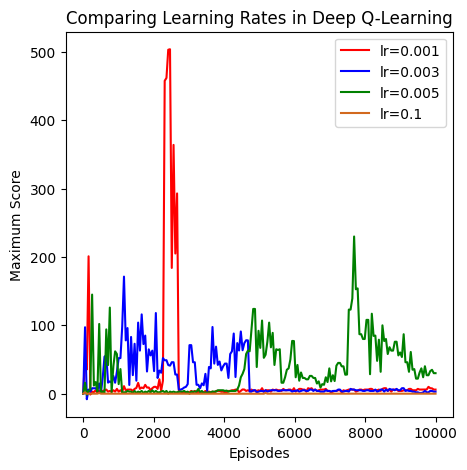

In [7]:
data001=pd.read_csv('data_lr0.001.csv').to_numpy()
data003=pd.read_csv('data_lr0.003.csv').to_numpy()
data005=pd.read_csv('data_lr0.005.csv').to_numpy()
data1=pd.read_csv('data_lr0.1.csv').to_numpy()
max001=data001[:,2]
max003=data003[:,2]
max005=data005[:,2]
max1=data1[:,2]
x001=data001[:,0]
x003=data003[:,0]
x005=data005[:,0]
x1=data1[:,0]
x001_smooth=np.linspace(x001.min(),x001.max(),200)
y001_smooth=make_interp_spline(x001,max001)(x001_smooth)
x003_smooth=np.linspace(x003.min(),x003.max(),200)
y003_smooth=make_interp_spline(x003,max003)(x003_smooth)
x005_smooth=np.linspace(x005.min(),x005.max(),200)
y005_smooth=make_interp_spline(x005,max005)(x005_smooth)
x1_smooth=np.linspace(x1.min(),x1.max(),200)
y1_smooth=make_interp_spline(x1,max1)(x1_smooth)
plt.figure(figsize=(5,5))
plt.plot(x001_smooth,y001_smooth,color='red',label='lr=0.001')
plt.plot(x003_smooth,y003_smooth,color='blue',label='lr=0.003')
plt.plot(x005_smooth,y005_smooth,color='green',label='lr=0.005')
plt.plot(x1_smooth,y1_smooth,color='chocolate',label='lr=0.1')
plt.xlabel('Episodes')
plt.ylabel('Maximum Score')
plt.title('Comparing Learning Rates in Deep Q-Learning')
plt.legend()
plt.savefig('comparison.png')
plt.show()

### CNN Model Structure
- Convolution layer with 32 filters and kernel size 5
- Maxpooling kernel size 10
- Convolution layer with 64 filters and kernel size 5
- Fully connected layer with 100 hidden nodes
- Output layer with 3 nodes corresponding to the data values

All layers have a RELU activation except the output layer which has a sigmoid activation. Each of the 3 output values are between 0 and 1 due to the sigmoid activation. The code for the CNN and its training is shown below.

In [ ]:
import torch
import torch.nn as nn
from constants import *

class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        mp1 = 10
        filters_1 = 32
        kernel_size_1 = 5
        filters_2 = 64
        kernel_size_2 = 5
        hidden = 100
        self.conv1 = torch.nn.Conv2d(3, filters_1, kernel_size_1)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=mp1, stride=mp1)
        self.conv3 = torch.nn.Conv2d(filters_1, filters_2, kernel_size_2)
        self.fc1 = torch.nn.Linear(filters_2 * (int((SCREEN_WIDTH - kernel_size_1 + 1)/mp1) - kernel_size_2 + 1) * (int((SCREEN_HEIGHT - kernel_size_1 + 1)/mp1)  - kernel_size_2 + 1), hidden)
        self.out = torch.nn.Linear(hidden, 6)


    def forward(self, x):
        first = self.conv1(x)
        m1 = nn.ReLU()
        first = m1(first)
        first = self.maxpool1(first)
        second = self.conv3(first)
        second = m1(second)
        second = second.view(second.size(0),-1)
        third = self.fc1(second)
        third = m1(third)
        output = self.out(third)
        m2 = nn.Sigmoid()
        return m2(output)

In [ ]:
def train(model, device, train_loader, train_outputs, optimizer, epoch):
    model.train()

    for batch_idx, (data,target) in enumerate(zip(train_loader, train_outputs)):
        data, target = data.type(torch.FloatTensor).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.MSELoss()
        l = loss(output, target)
        l.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), l.item()))

def test(model, device, test_loader, test_outputs):
    model.eval()
    test_loss = 0
    loss = nn.MSELoss()
    with torch.no_grad():
        for data, target in zip(test_loader, test_outputs):
            data, target = data.type(torch.FloatTensor).to(device), target.to(device)
            output = model(data)
            test_loss += loss(output, target).item()
    print(f"total loss is {test_loss}")

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss))


def main():
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data = torch.load('tensors.pt')
    output = torch.load('outputs.pt')
    print(data.size())
    train_size = int(0.65 * len(data))
    test_size = len(data) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size], generator = torch.Generator().manual_seed(42))
    train_output, test_output = torch.utils.data.random_split(output, [train_size, test_size], generator = torch.Generator().manual_seed(42))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
    train_outputs = torch.utils.data.DataLoader(train_output, batch_size=8, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
    test_outputs = torch.utils.data.DataLoader(test_output, batch_size=8, shuffle=False)
    # choose network architecture
    net = Conv().to(device)
    summary(net)
    if list(net.parameters()):
        # use SGD optimizer
        optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.1)

        # training and testing loop
        for epoch in range(1, 100 + 1):
            print(f"epoch is {epoch}")
            train(net, device, train_loader, train_outputs , optimizer=optimizer, epoch=epoch)
            test(net, device, test_loader, test_outputs)
    local_dir = os.path.dirname(__file__)
    file_path = os.path.join(local_dir, "conv.pth")
    torch.save(net.state_dict(), file_path)


Once the CNN model is trained it is able to output the 6 normalised data values:
- Bird_X / SCREEN_WIDTH
- Bird_Y / SCREEN_HEIGHT
- Pipe1_X / SCREEN_WIDTH
- Pipe1_Y / SCREEN_HEIGHT
- Pipe2_X / SCREEN_WIDTH
- Pipe2_Y / SCREEN_HEIGHT

By multiplying these values by either screen width or height we can get the coordinates for the bird and the top left corner of the two pipes. In the image below, the white spots represent the CNN's prediction of the bird and the top left corner of the pipes.

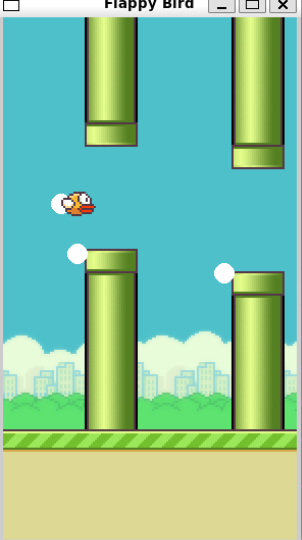

### Combining These Models
To combine the models, the CNN outputs (Bird x, Bird y, First Pipe x, First Pipe y, Second Pipe x, Second pipe y), will be used as inputs directly into the Q-Learning Model since it outperformed the Deep Q-Learning model. Note that due to velocity being difficult to track given the research time, it was decided to simply take velocity straight from the game values. There are a few ways this could have been implemented. One way is to change the rotational componenent of the bird image depending on its velocity. Another way would be to input a sequence of images rather than a single image, for example joining 5 successive frames together into a larger image which would allow the CNN to see the change in the birds position, allowing it to infer its velocity.

The values of the outputs of the CNN are in the range of 0 to 1. So, they are scaled back up to the screen size so that they can provide the coordinate positions for the input data values. These coordinates are then fed into the Q-Learning model creating a CNN Q-Learning model. A model that identifies pixel values through a CNN, uses these as inputs for a Q-Learning model, which finally outputs the "Flap" or "No Flap" condition.

The models were combined by modifying the mainGame() function used for Q-Learning as shown below. The function is shown below with the main changes shown in the form:


In [ ]:
############################################################################################################## 
# Main Change:
############################################################################################################## 
# code 
# is 
# in 
# here 
##############################################################################################################
##############################################################################################################

In [ ]:
def mainGame(movementInfo):
    # --- REMOVE ANGULAR MOVEMENT AND SOUNDS ---

    score = loopIter = 0
    playerx, playery = int(SCREENWIDTH * 0.2), movementInfo["playery"]

    basex = movementInfo["basex"]
    baseShift = IMAGES["base"].get_width() - IMAGES["background"].get_width()

    # get 2 new pipes to add to upperPipes lowerPipes list
    newPipe1 = getRandomPipe()
    newPipe2 = getRandomPipe()

    # list of upper pipes
    upperPipes = [
        {"x": SCREENWIDTH - 320, "y": newPipe1[0]["y"]},
        {"x": SCREENWIDTH - 320 + (SCREENWIDTH / 2), "y": newPipe2[0]["y"]},
    ]

    # list of lowerpipe
    lowerPipes = [
        {"x": SCREENWIDTH - 320, "y": newPipe1[1]["y"]},
        {"x": SCREENWIDTH - 320 + (SCREENWIDTH / 2), "y": newPipe2[1]["y"]},
    ]

    pipeVelX = -4

    # player velocity, max velocity, downward accleration, accleration on flap
    playerVelY = -9  # player's velocity along Y, default same as playerFlapped
    playerMaxVelY = 10  # max vel along Y, max descend speed
    playerAccY = 1  # players downward accleration
    playerFlapAcc = -9  # players speed on flapping
    playerFlapped = False  # True when player flaps

    # When starting the game, if we have state history to resume from then use it until it passes that pipe
    # If history is less than 20 frames this isn't enough for the bird to learn from (loop of dying) so clear the queue
    if len(STATE_HISTORY) < 20:
        STATE_HISTORY.clear()
    resume_from_history = (
        len(STATE_HISTORY) > 0 if Agent.train else None
    )  # only resume if training
    initial_len_history = len(STATE_HISTORY)
    resume_from = 0
    current_score = (
        STATE_HISTORY[-1][5] if resume_from_history else None
    )  # reset if beats the latest score in history
    print_score = False  # has the current score been printed?
    ##############################################################################################################
    # Main Changes: Loads the saved CNN model.
    ##############################################################################################################
    frames = []
    output = []
    local_dir = os.path.dirname(__file__)
    file_path = os.path.join(local_dir, "conv.pth")
    conv = Conv()
    conv.load_state_dict(torch.load(file_path))
    ##############################################################################################################
    while True:
        if resume_from_history:
            # Load from saved game history
            if resume_from < initial_len_history:
                if resume_from == 0:
                    (
                        playerx,
                        playery,
                        playerVelY,
                        lowerPipes,
                        upperPipes,
                        score,
                    ) = STATE_HISTORY[resume_from]
                else:
                    lowerPipes, upperPipes = (
                        STATE_HISTORY[resume_from][3],
                        STATE_HISTORY[resume_from][4],
                    )
                resume_from += 1
        else:
            # Save game history for resuming
            if (
                Agent.train
                and config["resume_score"]
                and score >= config["resume_score"]
            ):  # only save if training
                STATE_HISTORY.append(
                    [
                        playerx,
                        playery,
                        playerVelY,
                        copy.deepcopy(lowerPipes),
                        copy.deepcopy(upperPipes),
                        score,
                    ]
                )

        for event in pygame.event.get():
            if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                if print_score:
                    print("")

                # print(Agent.scores)
                cumulative_rewards = np.cumsum(Agent.scores)
                plot_cumulative_reward(cumulative_rewards)
                plot_learning_curve(Agent.scores)

                Agent.save_qvalues()
                Agent.save_training_states()
                pygame.quit()
                sys.exit()
            if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True

        # Agent to perform an action (0 is do nothing, 1 is flap)
        ##############################################################################################################
        # Main Changes: takes the screen and converts it to a tensor and preprocessed. CNN run on the result which
        # outputs the x,y coordinate for the bird and the pipes. These values are then fed into the Q-Learning model.
        ##############################################################################################################
        tensor = torch.from_numpy(pygame.surfarray.array3d(SCREEN)).permute(2,0,1).view(1,3,SCREENWIDTH,SCREENHEIGHT)
        tensor = tensor / 255
        pred = conv(tensor)[0]
        pred_pipes = []
        pred_pipes.append({"x" : pred[2] * SCREENWIDTH, "y" : pred[3] * SCREENHEIGHT})
        pred_pipes.append({"x" : pred[4] * SCREENWIDTH, "y" : pred[5] * SCREENHEIGHT})
        """ if config["vel"]:
            if Agent.act(playerx, playery, playerVelY, lowerPipes):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True
        else:
            if Agent.act(playerx, playery, 0, lowerPipes):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True """

        if config["vel"]:
            if Agent.act(pred[0] * SCREENWIDTH, pred[1] * SCREENHEIGHT, playerVelY, pred_pipes):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True
        else:
            if Agent.act(pred[0], pred[1], 0, pred_pipes):
                if playery > -2 * IMAGES["player"].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True

        ##############################################################################################################
        ##############################################################################################################
        # check for crash here
        crashTest = checkCrash({"x": playerx, "y": playery}, upperPipes, lowerPipes)
        if crashTest[0]:
            if print_score:
                print("")
            if resume_from_history:  # current_score is based on STATE_HISTORY
                # Managed to pass the difficult pipe
                if score > current_score:
                    Agent.update_qvalues(score)
                else:
                    REPLAY_BUFFER.append(copy.deepcopy(Agent.moves))
                # Or stuck in resume loop
                if score > current_score or len(REPLAY_BUFFER) >= 50:
                    # Update with a sample of the REPLAY_BUFFER (sample to avoid overfitting)
                    random.shuffle(REPLAY_BUFFER)
                    for _ in range(5):
                        if REPLAY_BUFFER:  # don't pop if list is empty
                            Agent.moves = REPLAY_BUFFER.pop()
                            Agent.update_qvalues(current_score)
                    STATE_HISTORY.clear()
                    REPLAY_BUFFER.clear()
            else:
                Agent.update_qvalues(score)  # only updates if training by default
            if Agent.train:
                print(
                    f"Episode: {Agent.episode}, alpha: {Agent.alpha}, score: {score}, max_score: {Agent.max_score}"
                )
            else:
                print(
                    f"Episode: {Agent.episode}, score: {score}, max_score: {Agent.max_score}"
                )
            return {
                "y": playery,
                "groundCrash": crashTest[1],
                "basex": basex,
                "upperPipes": upperPipes,
                "lowerPipes": lowerPipes,
                "score": score,
                "playerVelY": playerVelY,
            }

        # check for score
        playerMidPos = playerx + IMAGES["player"].get_width() / 2
        for pipe in upperPipes:
            pipeMidPos = pipe["x"] + IMAGES["pipe"][0].get_width() / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                score += 1
                # Print every 10k scores
                if score % config["print_score"] == 0:
                    print_score = True  # need to start a newline before future prints
                    print(
                        f"\r {'Training' if Agent.train else 'Running'} agent, "
                        f"score reached (nearest 10,000): {score:,}",
                        end="",
                    )
                if config["max_score"] and score >= config["max_score"]:
                    if print_score:
                        print("")
                    Agent.end_episode(score)
                    STATE_HISTORY.clear()  # don't resume if max score reached
                    REPLAY_BUFFER.clear()
                    print(
                        f"Max score of {config['max_score']} reached at episode {Agent.episode}..."
                    )
                    return {
                        "y": playery,
                        "groundCrash": crashTest[1],
                        "basex": basex,
                        "upperPipes": upperPipes,
                        "lowerPipes": lowerPipes,
                        "score": score,
                        "playerVelY": playerVelY,
                    }

        # playerIndex basex change
        loopIter = (loopIter + 1) % 30
        basex = -((-basex + 100) % baseShift)

        # player's movement
        if playerVelY < playerMaxVelY and not playerFlapped:
            playerVelY += playerAccY
        if playerFlapped:
            playerFlapped = False
            # # more rotation to cover the threshold (calculated in visible rotation)

        playerHeight = IMAGES["player"].get_height()
        playery += min(playerVelY, BASEY - playery - playerHeight)

        # move pipes to left if done loading
        if resume_from >= initial_len_history:
            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                uPipe["x"] += pipeVelX
                lPipe["x"] += pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < upperPipes[0]["x"] < 5:
            newPipe = getRandomPipe()
            upperPipes.append(newPipe[0])
            lowerPipes.append(newPipe[1])

        # remove first pipe if its out of the screen
        if upperPipes[0]["x"] < -IMAGES["pipe"][0].get_width():
            upperPipes.pop(0)
            lowerPipes.pop(0)

        # draw sprites
        SCREEN.blit(IMAGES["background"], (0, 0))

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            SCREEN.blit(IMAGES["pipe"][0], (uPipe["x"], uPipe["y"]))
            SCREEN.blit(IMAGES["pipe"][1], (lPipe["x"], lPipe["y"]))

        SCREEN.blit(IMAGES["base"], (basex, BASEY))
        ##############################################################################################################
        # Main Changes: puts white spots on the screen representing CNN prediction of bird and pipe positions
        ##############################################################################################################
        #pygame.draw.circle(SCREEN, (255, 255, 255,10), (int(pred[0]*SCREENWIDTH),int(pred[1]*SCREENHEIGHT)), 10)
        #pygame.draw.circle(SCREEN, (255, 255, 255,10), (int(pred[2]*SCREENWIDTH),int(pred[3]*SCREENHEIGHT)), 10)
        #pygame.draw.circle(SCREEN, (255, 255, 255,10), (int(pred[4]*SCREENWIDTH),int(pred[5]*SCREENHEIGHT)), 10)
        ##############################################################################################################
        ##############################################################################################################
        playerSurface = IMAGES["player"]
        SCREEN.blit(playerSurface, (playerx, playery))
        ##############################################################################################################
        # Main Changes: used to generate test data for CNN
        ##############################################################################################################
        #frames.append(tensor)
        if config["show_game"]:
            pygame.display.update()
        """ if len(lowerPipes) == 2:
            pipe1_x = lowerPipes[0]["x"] / SCREENWIDTH
            pipe1_y = lowerPipes[0]["y"] / SCREENHEIGHT
            pipe2_x = lowerPipes[1]["x"] / SCREENWIDTH
            pipe2_y = lowerPipes[1]["y"] / SCREENHEIGHT
        else:
            pipe1_x = lowerPipes[1]["x"] / SCREENWIDTH
            pipe1_y = lowerPipes[1]["y"] / SCREENHEIGHT
            pipe2_x = lowerPipes[2]["x"] / SCREENWIDTH
            pipe2_y = lowerPipes[2]["y"] / SCREENHEIGHT
        tensor = torch.tensor([playerx/SCREENWIDTH, playery/SCREENHEIGHT, pipe1_x, pipe1_y, pipe2_x, pipe2_y])
        output.append(tensor)
        if counter > 1500:
            print(counter)
        if counter > 2500:
            screenshots = torch.stack(frames)
            outputs = torch.stack(output)
            torch.save(screenshots, 'tensors.pt')
            torch.save(outputs, 'outputs.pt')
            break """
        ##############################################################################################################
        ##############################################################################################################
        FPSCLOCK.tick(FPS)


# Results

### Qlearning model training Results:

##### Not Scaled / No Velocity
The following graph was on a unscaled window (288 by 512 pixels) and the bird velocity was not provided to the model. The max score achieved was over 4000 after 10000 episodes. The rolling mean reward graph has stagnated showing that the model is unlikely to continue to improve with more episodes.

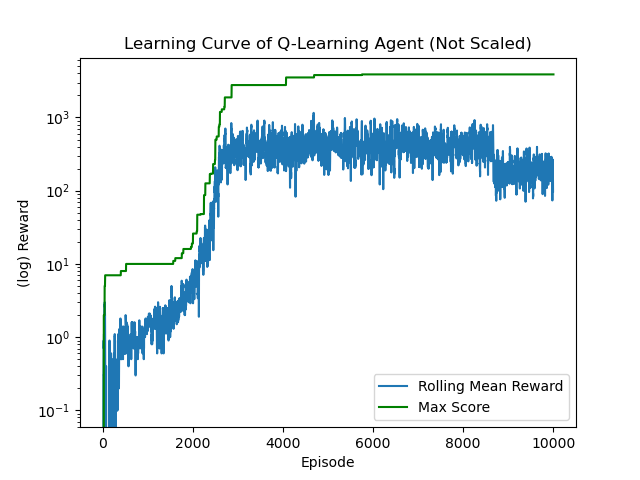

##### Scaled / No Velocity
The following graph was on a scaled window (550 by 850 pixels) and the bird velocity was not provided to the model. The max score achieved was over 300 after 40000 episodes. From the rolling mean reward we can see that the model made no consistent progress after 10000 episodes, but had a few variational spikes leading to a higher max score. As such, it performed worse compared to the not-scaled version above.
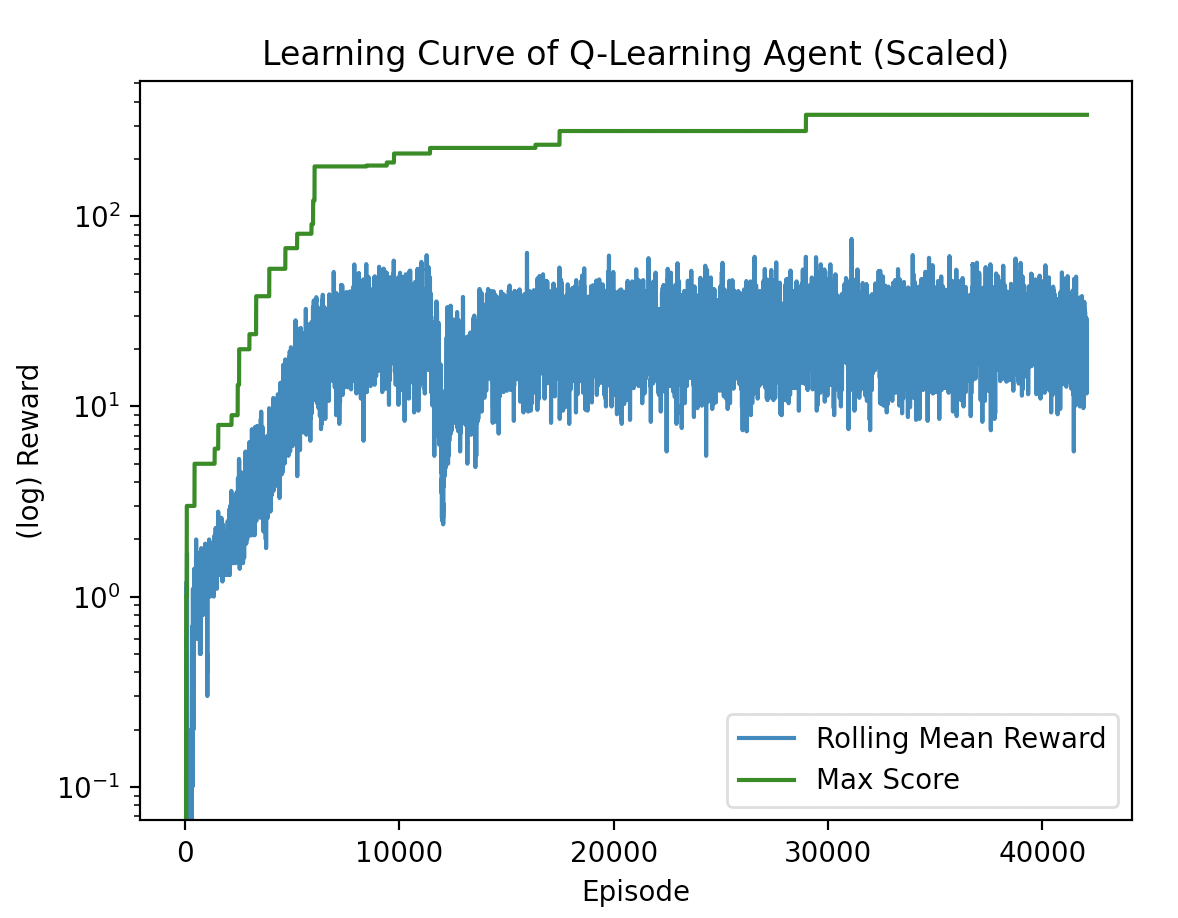

##### Not Scaled / Velocity
The following graph was on a unscaled window (288 by 512 pixels) and the bird velocity was provided to the model. The max score achieved was over 20000 after 17500 episodes. From the rolling mean reward we can see that the model was still making significant progress when it was stopped. So, if it was left for longer, it would be able to achieve a higher score. Overall, this model had much better overall performance compared to the previous models which were not given velocity.

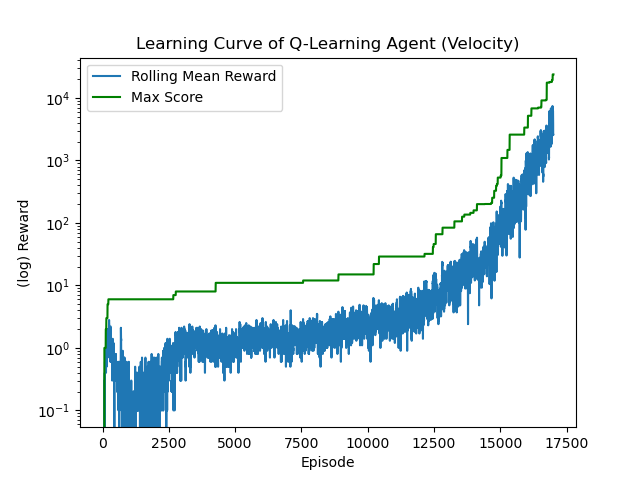

### NEAT model training Result:
NEAT finishes training in no more than 2 generations (usually in 1 generation) no matter how large the fitness threshold is set. So, it is able to create a perfect agent within 2 generations. Even when a large threshold score of 10,000,000 was set, the NEAT model was able to achieve it in 1 generation as shown in the output below.
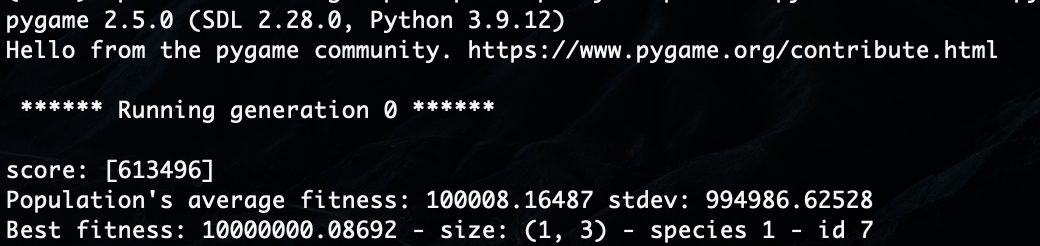




### DeepQ result

#### Maximum score with different learning rates
For each learning rate, after the bird reaches high scores, the bird falls into a ‘catastrophic forgetting’ problem with the maximum score dropping sequentially.  This is because our network is a linear network, which can't remember the long-time-period state. After each training set, the previous state is forgotten and the bird needs to be retrained again. From the learning rates, the highest score of 504 was achieved with a 0.001 learning rate, but rapidly converges to 0 score after 2500 episodes. While a learning rate of 0.005 has a max score more consistently in the 100s. Also a high learning rate of 0.1 causes the model to stop learning and the maximum score only fluctuates between 0 and 1.

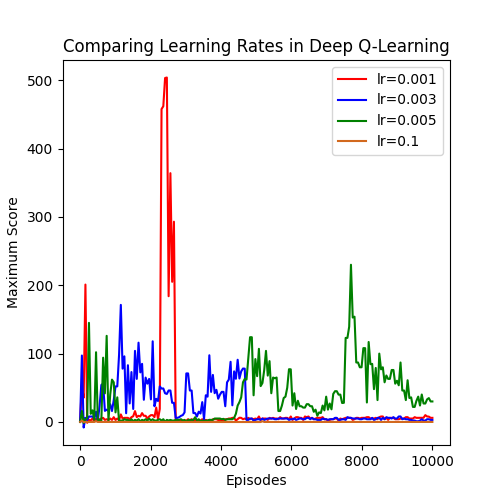


### CNN + Q-learning Result:

#### With bird velocity
The CNN + Q-Learning on an unscaled window size (288 by 512 pixels) was able to achieve a score of 157 when bird velocity was provided as shown in the graph below. The rolling mean reward is still increasing indicating that the model would continue to improve with more episodes.
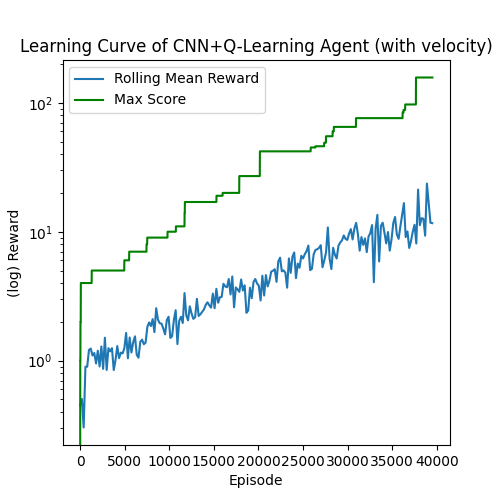

#### Without bird velocity
The CNN+Q-Learning on an unscaled window size (288 by 512 pixels) was able to achieve a maximum score of 4 after 30000 episodes, when bird velocity was not provided as shown in the graph below. The rolling mean reward is stagnant and so more episodes would unlikely cause an improvement. This performed significantly worse than the model which was given velocity.
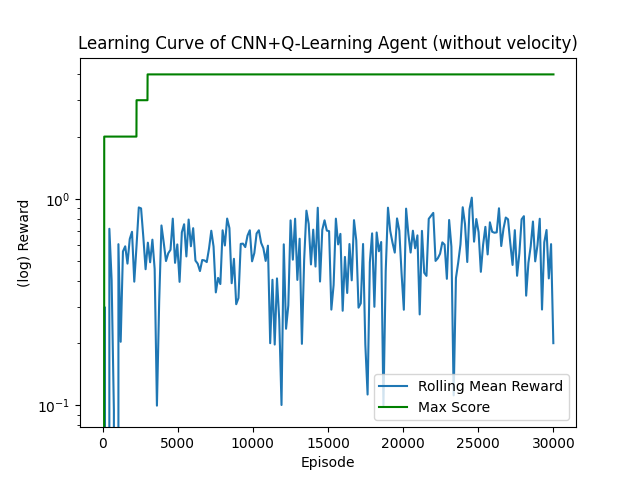



# Discussion

### Q-Learning model
The moving average (rolling mean reward), calculated over a window size of 100 episodes in this project, serves as a smoothing mechanism for the learning curve. It assists in mitigating the effects of noise and variability inherent in individual data points, thereby providing a clearer view of the overall trend in the model's learning journey. The essence of this approach lies in its ability to minimize the distraction of fluctuating raw rewards, thereby focusing on the broader picture of performance over time. As the moving average progressively rises, it is indicative of the ongoing improvement in our model's performance.

All the rolling mean curves and max score curve initially have the same upward trends, which suggest that the model is improving and finding better policies.

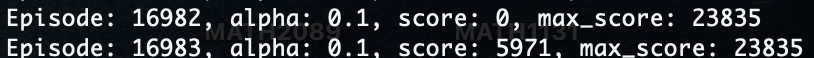

It is worth mentioning that even after tens of thousands of training episodes, the agent still gets 0 score sometimes. This also indicates model needs more training to understand the environment. These instances of 0 scores may be viewed as noise within the progression of the training data. This underlines the reason for implementing methodologies such as the rolling mean or moving averages when we aim to depict the average performance evaluation of the agent over time.

Normally Q-learning incorporates a balance between exploration (trying new actions) and exploitation (choosing the action that the model thinks is best). This balance is typically controlled by an "epsilon" parameter, which determines the likelihood that the model will select a random action for the purpose of exploration. If epsilon is not gradually decreased over time or is kept at a fixed high value, the agent will keep taking some random actions even after many episodes of training. This means the agent might still make some poor choices, which could lead to a score of zero.

But since we did not set "epsilon" parameter in our model, it could suggest that the agent hasn't learned enough about the environment and needs more training episodes.

##### Scaled vs Not-Scaled
In 10000 episodes the Q-Learning agent on the unscaled size is able to reach a score of 4000 while on the scaled size it only hits 300 after 40000 episodes. In both cases the maximum score curves are approaching flat eventually, which is expected as the Q-Learning algorithm continues to train it gets closer and closer to the optimal policy. At some point, the gains from further training start to diminish, which can lead to a plateau in the maximum score. This is reflected in the rolling mean reward which starts to stagnate after 10000 episodes for the Scaled and 30000 episodes for the Not-scaled.

By comparing the result of Scaled and Not-Scaled, it is obvious that Scaled model takes many more episodes of training to get moderate behavior. This is because once the game is scaled, there are more states and therefore a larger Q-TABLE. A larger state space means there are more possible states the agent can encounter. As a result, it needs more time (i.e., more training episodes) to explore all of these states and learn the optimal action for each.

##### Velocity vs without velocity
The Q-Learning model which is provided with the bird velocity initially learns slower than the one without. This is because When we incorporate the velocity into the model, the Q-table or state table becomes much larger since we now have another dimension - velocity. This increases the complexity of the problem and thus, the agent might need more episodes to explore and learn about the environment.

The model without velocity doesn't require as many episodes to reach a high score due to the smaller and simpler state table. However, the velocity-inclusive model outperforms the non-velocity model significantly towards the end because it uses a more informative state representation. By including velocity in the state representation, the agent has a better understanding of its situation in the environment allowing it to reach a score over 10000 after 17500 episodes. Furthermore, the rolling mean reward shows that the velocity model was still improving significantly after 17500 episodes while the model without velocity stagnated after 10000 episodes. So, the velocity model has great potential for improvements if run for a larger number of episodes.


##### Strengths & Weaknesses
Q-Learning is relatively straightforward to implement and understand, making it a good choice for simple reinforcement learning problems like Flappy Bird. However, it can be slow to converge, particularly in environments with many states and actions or with sparse rewards. We can easily notice the model converges much slower when the state table get larger.

For future improvement, we believe that combining model-based techniques with Q-Learning (like Dyna-Q) can speed up the learning process.

### NEAT
The NEAT algorithm is designed to evolve both the structure and weights of a neural network, effectively learning an optimal topology and set of parameters for a given problem. NEAT begins evolution with a population of simple networks and then allows both the number of neurons (complexity) and the set of connections to increase over generations.

For the Flappy Bird game, the training process finishes in at most 2 generations regardless of the value of target fitness. Even with a target score of 10,000,000, NEAT is able to achieve this within a generation as shown in the results. This suggests that NEAT algorithm is very efficient in evolving a model that is able to solve the Flappy Bird problem. NEAT's strength lies in its ability to find an optimal balance between network complexity and fitness, allowing for rapid convergence on a solution. The Flappy Bird game might be a relatively simple problem for NEAT to solve. Flappy Bird primarily requires understanding of timing for the 'flaps' to avoid pipes. NEAT could potentially figure out this mechanism quickly.

Although NEAT has such outstanding performance, there might be a risk of overfitting. The model might have learned to perform exceptionally well on the specific instances of the game seen during training, but it may not generalize well to new instances or slight variations of the game. This would be something to watch out for. To prevent overfitting, a penalty could be added for network complexity. By subtracting a portion of the complexity score from the performance score, the fitness function will encourage the evolution of networks that not only perform well but are also as simple as possible.

##### Strengths & Weaknesses
NEAT starts with simple networks and allows them to become increasingly complex over generations, only when the additional complexity provides a performance benefit. The major concern in our case is as mentioned earlier, NEAT can sometimes overfit to the training environment if not carefully managed. To combat this issue, we could add a penalty for network complexity to the fitness function altering the fitness function so that it not only considers the performance of the neural network (i.e., how well it does on the task), but also the complexity of the neural network (e.g., the number of nodes or connections).

### DeepQ

DeepQ uses epsilon to balance between exploration and exploitation. In deepQ, the epsilon is set to a high value at the beginning and gradually decreases with episodes increasing. At the beginning, the bird tries new actions and when epsilon drop to a low value, bird focuses on choosing best action. In deepQ, three-layer network is used to generate qvalues based on state.
After bird in deeq achieves high score, it encounters 'catastrophic forgetting' problems. The score drops gradually to low level, and after some training, bird reaches high score again. This is because during the trainning, the weight will be adjusted and information of old tasks is forgotten, which leads to bad performance. To solve this problem, more complex model or Elastic Weight Consolidation Method can be used.

##### Effect of learning rate on score

With learning rate increasing, the catastrophic forgetting period can be reduced and bird can achieve high score in shorter time. However, learning rate can not be increased infinitely. When it reaches a threshold, the large learning rate prevents the model from learning. In deepQ, the threshold is 0.1 after which the model is unable to learn and has scores which fluctuate between 0 and 1. From the learning rates, the highest score was 504 which was achieved with a 0.001 learning rate, but rapidly converged to 0 score after 25000 episodes. While a learning rate of 0.005 has a max score more consistently in the 100s.

##### Strengths & Weaknesses
Since DeepQ can learn directly from the environment, it can be easily adapted to different tasks and environment. However, deepQ can be unstable during the training set and it is hard to achieve convergency. DeepQ has better performance in dealing with discrete action spaces. For problems with coninuous actions spaces, additional techniques are required.

### CNN + Q-Learning

After testing all three models, we decided to combine CNN with the model of best performance. In this case, Q-learning is combined with CNN. In CNN + Q-Learning, the model takes current environment of Flappy Bird and uses CNN to generate related data of bird and pipes. After that, the data values are used as input to choose action. The max-score increases gradually with the increase of the number of episodes. The max score when velocity was provided was 157, but the max score without velocity was 4. The rolling mean reward indicates that the velocity model was still learning and improving whilst the no velocity model had stagnated.

While the CNN + Q-Learning model has a far lower score than the other models, it is a far better representation of a human playing the game. It is able to achieve comparatively higher scores than a human player would. Furthermore, it has the advantage of not relying on the game implementation like the other models, making it applicable to many versions of the game. It should be noted that to achieve high scores, CNN + Q-Learning takes more episodes than other models, since the positional coordinates of the bird and pipes are not exact. Furthermore, the CNN needs to be applied every frame causing the entire training process to be very time consuming.

##### Velocity vs no velocity

For CNN + Q-Learning, the velocity is a significant element in choosing aciton. The model with velocity has much better performance than the model without velocity. This makes sense, since without knowing the bird’s velocity, the model doesn’t know if the bird will move up or down in the next frame. For a CNN-based model, the velocity can’t be given directly through the screen image. One potential way to circumvent this issue is to pass in a sequence of consecutive screen frames which show the bird moving. This could be done by augmenting the data and connecting 4 consecutive frames into a larger image and using the resultant image as the input. This approach should be tested in future work, to see if it is able to alleviate the issue of determining velocity directly through the CNN.



##### Strengths & Weaknesses

CNN + Q-Learning is a time-consuming algorithm, and so it will take far longer for a perfect model to be achieved compared to the other models. Furthermore, before being applied to real tasks, CNN + Q-Learning needs to be trained with a large amount of data.  However, the advantage is that it is able to be applied on different window sizes and implementations of the game, which none of the other models can do. Also in doing so, it is the best representation of a human player and it is able to outperform an average human player.



## Comparisons
Among the base models, NEAT performed the best as it was able to create a perfect agent within 1 generation. The second best model was Q-Learning with velocity which managed to reach a score over 4000. The worst base model was Deep Q-Learning which only managed to achieve a score of 504.

The CNN+Q-Learning model with velocity had a much lower score compared to the base models. But it still achieved a higher score compared to an average human player. As such it is considered to be a successful model, since it is the best representation of a human player and it is able to outperform human players. It also still had an increasing rolling mean reward indicating that it would continue to improve with more training.

## Conclusion
Among all base models, NEAT had the best performance, followed by Q-Learning. Deep-Q learning had the worst performance among the base models. From our testing, CNN+Q-learning had worse performance than the base models, but still achieved a higher score than an average human player. If the CNN+Q-Learning model with velocity was trained for a longer time, it would have better performance. Overall, we achieved our goal of achieving a high score with reinforcement learning and managed to create a successful model using a CNN.
